**Project Title: IMDb movie genre classifier with LSTM**

**Project group:**

Group member 1
Name: Daniela Raygadas -- Email: dr976@drexel.edu

Group member 2
Name: Om Prakash Singh -- Email: os338@drexel.edu

Group member 3
Name: Dayun Piao  -- Email: dp636@drexel.edu

Group member 4
Name: Hari Prasad Kotapalli -- Email: hk672@drexel.edu


**Introduction**:

A class of category of artistic endeavour having a particular form, content, technique or the like, as far as a video content is concerned. Movie-genre is the name we use to describe the categories that have developed overtime for what we read, what we watch, what we listen to, and the kinds of classification that exists in wide range of IMDB movie collections.


In this wide collection of international movies, there exists a sub-classification of Objective and Subjective:

1. Objective Genres: These are not influenced by personal feelings or opinions in considering and representing facts. These are hard coded to the set rules of our guidelines.

2. Subjective Genres: These are common in most modern films and may be influenced by viewer opinions, interpretations, points of view, emotions, and judgement.
 

The different film genres and television categories which are broadly in use: Action, Adventure, Comedy, drama, fantasy, historical epic, horror, musical, romance, science fiction, thriller, war & documentary. 



**Project Aim:**

Our goal for this project was to produce a genre classifier based on the deep learning architecture of LSTMs. The pipeline of this text classification model could fit in other applications such as categorizing books into different genres according to book description or abstract. Or any other general text data classification task with given sets of labels. 

1. Multi-class text classification
2. LSTM - Long Short Term Memory networks
3. Keras as Framework 
4. Glove & Sequential models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.model_selection import train_test_split

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras import callbacks

In [ ]:
##Loading dataset

df = pd.read_csv('/content/drive/My Drive/DSCI691_Project/IMDb_movies.csv') 

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The IMDB movies dataset has in total 85,855 rows and 23 columns. Each row corresponds to a movie and the columns describe different attributes of the movies such as the title, year, data_published, genre, duration and many others. 

In [ ]:
df.shape

(85855, 22)

In [ ]:
df.head(3)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0


After inspecting our dataset we observed that we can have multiple genres associated to a movie. For this project we decided to only focus on one genre per movie. Therefore, in the next step we have to do some preprocessing in which we only take the first genre and created a new column called first_label that describes the genre associated to that movie.

In [ ]:
df["first_label"] = df["genre"].apply(lambda row: row if ',' not in row else row.split(',')[0])

In [ ]:
df.head(3)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,first_label
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0,Romance
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0,Biography
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0,Drama


Next, for this project we are only interested in two columns, the description of the movie that we will be using to predict the genre of the movie and the first_label which is the actual genre that the movie is associated with and this label will help us evaluate the performance of our model

In [ ]:
complete_df = df[['first_label', 'description']] #Selecting only two columns for our project from df dataframe 

Moreover, we are also removing any movie that is missing a description as for this project we are interested in this particular column and we want to make sure we do not have any missing values. 

In [ ]:
complete_df = complete_df.dropna(subset = ['description'])# removing records where the description is missing
complete_df.reset_index(drop=True,inplace=True) # resetting the index of dataframe

After removing the missing values, there are 83,740 movies remaning in our dataset

In [ ]:
complete_df.count

<bound method DataFrame.count of       first_label                                        description
0         Romance  The adventures of a female reporter in the 1890s.
1       Biography  True story of notorious Australian outlaw Ned ...
2           Drama  Two men of high rank are both wooing the beaut...
3           Drama  The fabled queen of Egypt's affair with Roman ...
4       Adventure  Loosely adapted from Dante's Divine Comedy and...
...           ...                                                ...
83735       Drama  An unusual bond between a sixty year old Dalit...
83736      Comedy  Manoharan is a poster artist struggling to fin...
83737      Comedy  A psychiatric hospital patient pretends to be ...
83738      Comedy  A middle-aged veterinary surgeon believes his ...
83739       Drama  Pep, a 13-year-old boy, is in love with a girl...

[83740 rows x 2 columns]>

**Data Pre-processing:**

In [ ]:
import re

def clean_text(x):
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;-]')# special character 
  BAD_SYMBOLS_RE = re.compile('[^a-zA-z0-9\s]') # alphanumeric charater
  text = x.lower() # lower case

  text = REPLACE_BY_SPACE_RE.sub('', text) # applying regex to subset the text.
  text = BAD_SYMBOLS_RE.sub('', text)
  return text                              # returning the final cleaned text

In [ ]:
complete_df['description'] = complete_df['description'].apply(clean_text)

We next looked at how many movies we have belonging to the 23 movie genre present in our dataset. As we can see, we have a highly imbalanced dataset and a large number of classes to predict from. This could become a problem for our model as there are some classes that have very few instances as low as 2 instances. Therefore, we decided to explore both options and compare both models. One model having all 23 classes and the second model having only the classes with the most instances in this case we took the classes that had over 1000 instances which would leave us with 9 classes. 


In [ ]:
genre_counts = complete_df.first_label.value_counts() # counting the distribution of each genre instances
genre_counts

Drama          24766
Comedy         23297
Action         12054
Crime           5502
Horror          5082
Adventure       3522
Animation       2063
Biography       2034
Thriller        1346
Romance          740
Western          616
Family           607
Mystery          588
Fantasy          496
Sci-Fi           415
Musical          313
War              102
History           74
Music             74
Film-Noir         29
Sport             16
Adult              2
Documentary        2
Name: first_label, dtype: int64

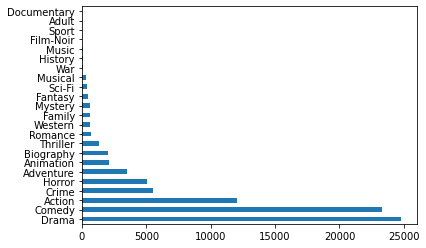

In [ ]:
genre_counts.plot.barh()

We then looked at the description length distribution. 

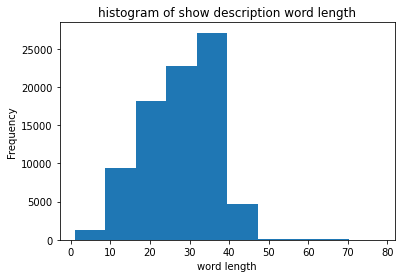

word length at 90 percentile: 37.0
word length at 91 percentile: 38.0
word length at 92 percentile: 38.0
word length at 93 percentile: 39.0
word length at 94 percentile: 39.0
word length at 95 percentile: 40.0
word length at 96 percentile: 41.0
word length at 97 percentile: 42.0
word length at 98 percentile: 43.0
word length at 99 percentile: 44.0


In [ ]:
def get_description_len(x): 
    return len(x.split())            # spliting the parameters value 

complete_df['len'] = complete_df.description.apply(get_description_len) # finding the lenth of description
complete_df['len'].plot(kind='hist')                                    # ploting length
plt.title('histogram of show description word length')   #title label
plt.xlabel('word length')                                # x-axis label 
plt.show()
for i in np.arange(0.9,1,0.01):                                # on range 0.9 to 1 with incremental of .01
    p = complete_df.len.quantile(i)                            # 
    print(f'word length at {int(i*100)} percentile:',p)        # printing word length on percentile

Our reduced dataframe contains the 9 classes that have over 1000 instances. And we would be using this data to build our final model. 

In [ ]:
most_count_labels = ['Drama','Comedy','Action','Crime','Horror','Adventure','Animation','Biography','Thriller']  # list of column name 
reduced_df = complete_df[complete_df['first_label'].isin(most_count_labels)]      # only taking the column which is in most column label i.e over 1000 instances 
reduced_df.first_label.value_counts()     # counting the occurence of instances with each label(genre) 

Drama        24766
Comedy       23297
Action       12054
Crime         5502
Horror        5082
Adventure     3522
Animation     2063
Biography     2034
Thriller      1346
Name: first_label, dtype: int64

Now let's vectorize the movie description and convert it from text to a sequence of numbers. The sequence of numbers are determined from above EDA on description length distribution. At length of 44 represents about 99% of all the description. Embedding dimension is set at 100. 

In [ ]:
# Max number of words in each description.
MAX_SEQUENCE_LENGTH = 44
EMBEDDING_DIM = 100

fit_on_texts updates internal vocabulary based on a series of tests in 'description', word_index is the vocabulary set for all the unique words in all the descriptions. Each token is associated with an index. 

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(complete_df['description'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 81764 unique tokens.


tests_to_sequences converts text in description to integers based on results from fit_on_texts. Fit tokenizer once and sequence many later on. Keeping all the text in the same length of 44 using pad_sequences. Truncating longer text and padding shorter text with zeros.

In [ ]:
text = tokenizer.texts_to_sequences(complete_df['description'].values)
text = pad_sequences(text, maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', text.shape)

Shape of data tensor: (83740, 44)


Converting labels from categorical values into numbers by using pd.get_dummies which simply using indicator numerical variables to indicate the labels 

In [ ]:
label = pd.get_dummies(complete_df['first_label']).values
label_names = list(pd.get_dummies(complete_df['first_label']).columns)
print(len(label_names))
print('Shape of label:', label.shape)

23
Shape of label: (83740, 23)


The whole dataset are split to train and test with random_state of 42 to make it reproducible, stratify of label to make sure split proportionally per label.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(text, label, test_size = 0.2, random_state = 42, stratify = label)
print(f"train shape -- x: {x_train.shape}, y: {y_train.shape}")
print(f"test shape -- x: {x_test.shape}, y: {y_test.shape}")

train shape -- x: (66992, 44), y: (66992, 23)
test shape -- x: (16748, 44), y: (16748, 23)


The structure of LSTM model:

*   Embedding: The first layer is embedding layer with embedding dimension of 100 represents each word.
*   SpatialDropout1D: Performs spatial 1D verision of dropout in the model and drops entire 1D feature maps instead of individual elements
*   LSTM: LSTM layer with 100 memory units
*   Dense: a output layer that will have 23 outcomes per class and activation function of Softmax for multi-class classification
*   Loss: categorical_crossentropy is chosen for multi-class classification






In [ ]:
model = Sequential()
model.add(Embedding(len(word_index)+1, EMBEDDING_DIM, input_length = text.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(23, activation = 'softmax'))
# opt = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

epochs = 10
batch_size = 64
earlystopping = callbacks.EarlyStopping(monitor = 'val_loss', mode = "min", patience = 3, verbose = 1, min_delta = 0.0001)

history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, 
                    callbacks = [earlystopping], validation_split = 0.1)


Epoch 1/10
943/943 [==============================] - 255s 247ms/step - loss: 2.0251 - accuracy: 0.3082 - val_loss: 1.7063 - val_accuracy: 0.4275
Epoch 2/10
943/943 [==============================] - 234s 248ms/step - loss: 1.5065 - accuracy: 0.5168 - val_loss: 1.5466 - val_accuracy: 0.4951
Epoch 3/10
402/943 [===========>..................] - ETA: 2:15 - loss: 1.1288 - accuracy: 0.6548

The epoch stops at number 5 due to early call of detecting increase in validation's loss. The weighted average accuracy of model is 0.43 and loss of 0.45, f1 of 0.43. Given the task to predict labels as much as 23, it will be very hard to have high accuracy especially with highly inbalanced label distribution across out the whole dataset.

*   The precision is how many are correctly classified mong that class
*   The recall is how many of this class over the whole number of elements of this class or sensitivity
*   The f1 score is the harmonic mean between the precision and the recall
*   The support is how many occurence of the given class in the dataset





In [ ]:
from sklearn.metrics import classification_report
y_pred= model.predict(x_test, batch_size=batch_size, verbose=2)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test,axis=1)
report = classification_report(y_test_classes, y_pred_classes)
print(report)

262/262 - 3s
              precision    recall  f1-score   support

           0       0.47      0.48      0.47      2411
           2       0.19      0.18      0.19       704
           3       0.43      0.27      0.34       413
           4       0.45      0.23      0.30       407
           5       0.52      0.53      0.52      4660
           6       0.25      0.26      0.25      1100
           8       0.47      0.56      0.51      4953
           9       0.09      0.02      0.03       121
          10       0.00      0.00      0.00        99
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00        15
          13       0.38      0.49      0.43      1017
          14       0.00      0.00      0.00        15
          15       0.00      0.00      0.00        63
          16       0.20      0.02      0.03       118
          17       0.00      0.00      0.00       148
          18       0.00      0.00      0.00        83
          19  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


The plot below of loss and accuracy shows that the model doesn't have the ability to generailzed all the data. The trained model is overfitted and several actions could improve this stage. The first is to use pre-trained embedding, and another is to limit the predicting label so that each class has sufficient amount of data.

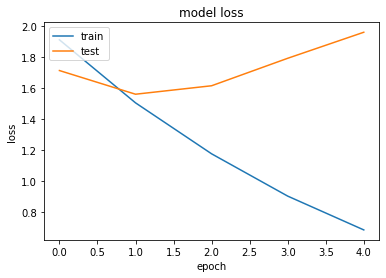

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

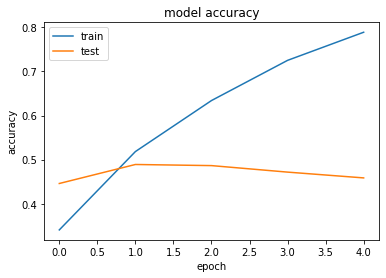

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In order to improve the model performance, one experiment could be conducted is to use pre-trained word vectors. The GloVe pretrained word vector package is downloaded through gensim's api.

In [ ]:
import gensim.downloader as api

word_dim = 100
glove_model = api.load(f"glove-wiki-gigaword-{word_dim}")

[==================================================] 100.0% 128.1/128.1MB downloaded


Building a embedding_matrix for later input to the LSTM model. The embedding matrix is bascially building a matrix for each vocabulary in the movie description with the vector value from GloVe, if the vocabulary is not in the GloVe, use zeros instead and ignore those.

In [ ]:
#not updating set to 0 

embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in glove_model:
      # words not found in embedding index will be all-zeros.
      embedding_matrix[i] = glove_model[word]

For the LSTM model, all the structure layers are same as in the previous model except the embedding layer is now tied with embedding matrix just built.

In [ ]:
model_2 = Sequential()
model_2.add(Embedding(len(word_index)+1, EMBEDDING_DIM,embeddings_initializer=keras.initializers.Constant(embedding_matrix),input_length = text.shape[1],trainable=False))
model_2.add(SpatialDropout1D(0.2))
model_2.add(LSTM(100, dropout = 0.2, recurrent_dropout = 0.2))
model_2.add(Dense(23, activation = 'softmax'))
opt = keras.optimizers.Adam(learning_rate = 0.001)
model_2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

epochs = 10
batch_size = 64
earlystopping = callbacks.EarlyStopping(monitor = 'val_loss', mode = "min", patience = 3, verbose = 1, min_delta = 0.0001)

history = model_2.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, 
                    callbacks = [earlystopping], validation_split = 0.1)

Epoch 1/10
943/943 [==============================] - 150s 156ms/step - loss: 1.9253 - accuracy: 0.3472 - val_loss: 1.5949 - val_accuracy: 0.4627
Epoch 2/10
943/943 [==============================] - 144s 153ms/step - loss: 1.6170 - accuracy: 0.4483 - val_loss: 1.5487 - val_accuracy: 0.4766
Epoch 3/10
943/943 [==============================] - 146s 155ms/step - loss: 1.5635 - accuracy: 0.4641 - val_loss: 1.5107 - val_accuracy: 0.4793
Epoch 4/10
943/943 [==============================] - 144s 153ms/step - loss: 1.5418 - accuracy: 0.4696 - val_loss: 1.5019 - val_accuracy: 0.4816
Epoch 5/10
943/943 [==============================] - 145s 153ms/step - loss: 1.5071 - accuracy: 0.4772 - val_loss: 1.4969 - val_accuracy: 0.4855
Epoch 6/10
943/943 [==============================] - 142s 151ms/step - loss: 1.4932 - accuracy: 0.4896 - val_loss: 1.4857 - val_accuracy: 0.4893
Epoch 7/10
943/943 [==============================] - 142s 151ms/step - loss: 1.4937 - accuracy: 0.4873 - val_loss: 1.4719 -

In this experiment, the early stop call didn't occur and model is able to run the desired number of epoch times. All the evaluation metrics have some incresae compared to previous model. But still, model failed for some labels. Since class like 'Adult', 'Documentary' and etc are having lack of insufficient data. So the next experiment would to try threshold the class labels for predicting.

In [ ]:
from sklearn.metrics import classification_report
y_pred= model_2.predict(x_test, batch_size=batch_size, verbose=2)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test,axis=1)
report = classification_report(y_test_classes, y_pred_classes)
print(report)

262/262 - 3s
              precision    recall  f1-score   support

           0       0.50      0.56      0.53      2411
           2       0.34      0.13      0.19       704
           3       0.42      0.33      0.37       413
           4       0.54      0.38      0.44       407
           5       0.53      0.58      0.56      4660
           6       0.35      0.22      0.27      1100
           8       0.51      0.63      0.56      4953
           9       0.17      0.01      0.02       121
          10       0.00      0.00      0.00        99
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00        15
          13       0.46      0.47      0.47      1017
          14       0.00      0.00      0.00        15
          15       0.00      0.00      0.00        63
          16       0.00      0.00      0.00       118
          17       0.00      0.00      0.00       148
          18       0.07      0.02      0.04        83
          19  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


On big improvemnt in this experiment is that the model gains generalized ability for test data set as shown below in loss and accuracy graph.

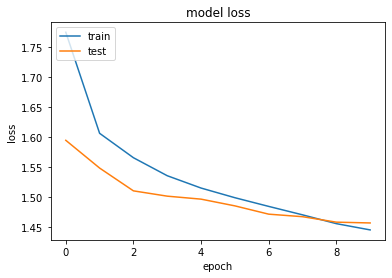

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

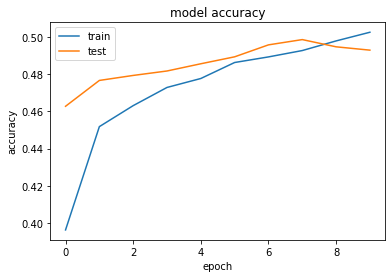

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

From here, the last experiemnt is to reduce the amount of labels to predict, threshold the label which has more than 1000 data in the dataset:
*   Drama
*   Comedy
*   Action
*   Crime
*   Horror
*   Adventure
*   Animation
*   Biography
*   Thriller




In [ ]:
reduced_tokenizer = Tokenizer()
reduced_tokenizer.fit_on_texts(reduced_df['description'].values)
reduced_word_index = reduced_tokenizer.word_index
print('Found %s unique tokens.' % len(reduced_word_index))

reduced_text = reduced_tokenizer.texts_to_sequences(reduced_df['description'].values)
reduced_text = pad_sequences(reduced_text, maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', reduced_text.shape)

reduced_label = pd.get_dummies(reduced_df['first_label']).values
reduced_label_names = list(pd.get_dummies(reduced_df['first_label']).columns)
print(len(reduced_label_names))
print('Shape of label:', reduced_label.shape)

x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = train_test_split(reduced_text, reduced_label, test_size = 0.2, random_state = 42, stratify=reduced_label)
print(f"train shape -- x: {x_train_reduced.shape}, y: {y_train_reduced.shape}")
print(f"test shape -- x: {x_test_reduced.shape}, y: {y_test_reduced.shape}")

Found 79437 unique tokens.
Shape of data tensor: (79666, 44)
9
Shape of label: (79666, 9)
train shape -- x: (63732, 44), y: (63732, 9)
test shape -- x: (15934, 44), y: (15934, 9)


In [ ]:
reduced_embedding_matrix = np.zeros((len(reduced_word_index)+1, EMBEDDING_DIM))
for word, i in reduced_word_index.items():
    if word in glove_model:
      # words not found in embedding index will be all-zeros.
      reduced_embedding_matrix[i] = glove_model[word]

All the hyperparameters are same as previous models except in the final activation layer it outputs 9 labels now.

In [ ]:
final_model = Sequential()
final_model.add(Embedding(len(reduced_word_index)+1, EMBEDDING_DIM,embeddings_initializer=keras.initializers.Constant(reduced_embedding_matrix),input_length = reduced_text.shape[1],trainable=False))
final_model.add(SpatialDropout1D(0.2))
final_model.add(LSTM(100, dropout = 0.2, recurrent_dropout = 0.2))
final_model.add(Dense(9, activation = 'softmax'))
opt = keras.optimizers.Adam(learning_rate = 0.001)
final_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

epochs = 10
batch_size = 64
earlystopping = callbacks.EarlyStopping(monitor = 'val_loss', mode = "min", patience = 3, verbose = 1, min_delta = 0.0001)

history_final = final_model.fit(x_train_reduced, y_train_reduced, epochs = epochs, batch_size = batch_size, 
                    callbacks = [earlystopping], validation_split = 0.1)

Epoch 1/10
897/897 [==============================] - 142s 155ms/step - loss: 1.6225 - accuracy: 0.3855 - val_loss: 1.3796 - val_accuracy: 0.4870
Epoch 2/10
897/897 [==============================] - 139s 155ms/step - loss: 1.4122 - accuracy: 0.4749 - val_loss: 1.3292 - val_accuracy: 0.4987
Epoch 3/10
897/897 [==============================] - 137s 153ms/step - loss: 1.3760 - accuracy: 0.4864 - val_loss: 1.3188 - val_accuracy: 0.5107
Epoch 4/10
897/897 [==============================] - 134s 150ms/step - loss: 1.3513 - accuracy: 0.4961 - val_loss: 1.2898 - val_accuracy: 0.5180
Epoch 5/10
897/897 [==============================] - 140s 156ms/step - loss: 1.3299 - accuracy: 0.5018 - val_loss: 1.2913 - val_accuracy: 0.5215
Epoch 6/10
897/897 [==============================] - 141s 157ms/step - loss: 1.3077 - accuracy: 0.5115 - val_loss: 1.2821 - val_accuracy: 0.5220
Epoch 7/10
897/897 [==============================] - 140s 156ms/step - loss: 1.2946 - accuracy: 0.5174 - val_loss: 1.2812 -

The evaluation results for final model are better than the previous models and achieved final weighted average precision of 0.51 and recall of 0.52. Model didn't fail on any single label and able to produce probability for each.

In [ ]:
y_pred_final= final_model.predict(x_test_reduced, batch_size=batch_size, verbose=2)
y_pred_classes_final = np.argmax(y_pred_final, axis=1)
y_test_classes_final = np.argmax(y_test_reduced,axis=1)
report_final = classification_report(y_test_classes_final, y_pred_classes_final)
print(report_final)

249/249 - 3s
              precision    recall  f1-score   support

           0       0.53      0.52      0.53      2411
           1       0.33      0.16      0.22       704
           2       0.51      0.32      0.39       413
           3       0.61      0.38      0.47       407
           4       0.56      0.60      0.58      4660
           5       0.38      0.19      0.26      1101
           6       0.52      0.63      0.57      4953
           7       0.45      0.50      0.47      1016
           8       0.29      0.01      0.01       269

    accuracy                           0.52     15934
   macro avg       0.46      0.37      0.39     15934
weighted avg       0.51      0.52      0.51     15934



In [ ]:
print(history_final.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


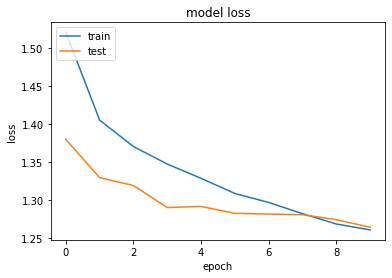

In [ ]:
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

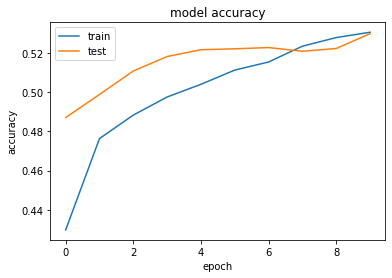

In [ ]:
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

### Results for all the models:

| Model | Weighted F1 score | 
| --- | ----------- |
| Embedding Layer/full set of classes | 0.43 |
| Pre-trained word vectors/ full set of classes|  0.47|
|Pre-trained word vectors/ reduced classes| 0.51| 



Challenges:
*   Description was not complete 
*   Class label (multi label)
*   Highly imblance dataset

Future Work
*   Trying other models as CNN
*   Multi-label classification
*   Hyperparameter tunning on the model
*   Ensemble LSTM and CNN
*   Try different pretrained word vectors (Word2Vec)
*   Using other deep learning framework as Pytorch or TensorFlow
*   Adding geological embedding, and 'country' feature. Maybe for certain country, there is a tendency to have certain genre type produce.




